
Rodent silent substitution
==========================

Silent substitution has been applied to study the effects of melanopic stimulation on circadian responses in mice (e.g., [Mouland et al., 2021](https://onlinelibrary.wiley.com/doi/10.1111/jpi.12735)). This example demonstrates how to create a custom `Rodent` observer class and prepare cone-silent melanopsin modulations for a BGRW projector. Let's assume that the device will project onto a pane of diffusive material above a chamber containing the mouse. Note that the the following workflow may be applied for any custom observer whose action spectra are available.

These action spectra were obtained from the Rodent Toolbox ([Lucas et al., 2014](https://www.cell.com/trends/neurosciences/fulltext/S0166-2236(13)00197-5)). Note that mice do not possess a third cone, and that the spectral sensitivities peak at different locations in the visual spectrum in comparison to humans. In particular, S-cone sensitivity is shifted leftwards towards the near-UV portion of the spectrum and there is increased overlap of the M-cone, melanopic and rhodopic action spectra.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pysilsub import problems, observers

# Load the rodent action spectra
rodent_action_spectra = pd.read_csv(
    '../../pysilsub/data/rodent_action_spectra.csv',
    index_col='Wavelength'
)
rodent_action_spectra

,sc,mel,rh,mc
Wavelength,,,,
300,0.004086,0.000754,0.000676,0.000577
301,0.005899,0.001042,0.000905,0.000804
302,0.008776,0.001530,0.001312,0.001195
303,0.012715,0.002220,0.001898,0.001749
304,0.017718,0.003110,0.002662,0.002467
...,...,...,...,...
776,0.000000,0.000000,0.000000,0.000000
777,0.000000,0.000000,0.000000,0.000000
778,0.000000,0.000000,0.000000,0.000000


Assigned new (probably not suitable) colors for action spectra.


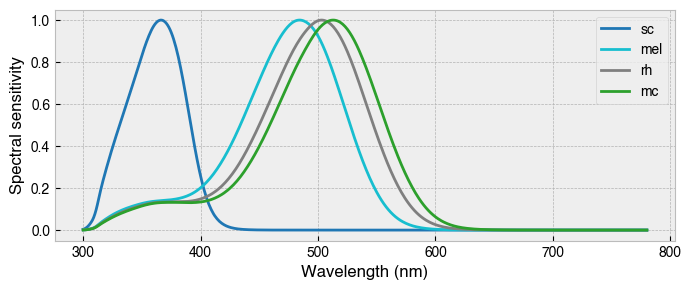

In [2]:
# Create custom rodent model using the _Observer base class
class Rodent(observers._Observer):
    def __init__(self):
        super().__init__()

# Instantiate observer class
mouse = Rodent()

# Assign rodent action spectra
mouse.action_spectra = rodent_action_spectra

# Override list of photoreceptors and colors used for plotting
mouse.photoreceptors = mouse.action_spectra.columns.tolist()
mouse.photorecptor_colors = {
        "sc": "tab:blue",
        "mel": "tab:cyan",
        "rh": "tab:grey",
        "mc": "tab:green"
}

# Plot action spectra
mouse.plot_action_spectra(figsize=(8, 3));

Now that we have prepared the `Rodent` observer we need to set up the problem. Here, we will use example package data for a BGRW overhead projection system.

The trick to making things go smoothly is to ensure that the calibration spectra of the stimulation device are sampled at the same wavelengths as the photoreceptor action spectra of the observer. The calibration spectra for the projector were originally sampled from 380-780 nm, so we need to reindex them in order to align the matrices.

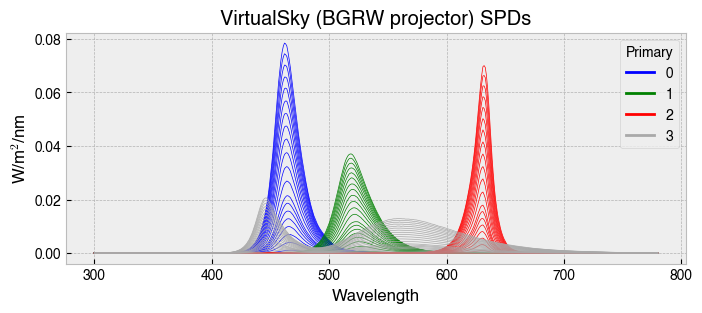

In [3]:
# Load example data for BGRW projector
ssp = problems.SilentSubstitutionProblem.from_package_data('VirtualSky')

# Align the matrices for spds and spectral sensitivities. This
# just adds a bunch of zeros to the left of each calibration spectrum.
ssp.calibration = ssp.calibration.reindex(range(300, 781, 1), axis=1).fillna(0)

# Plot spds
fig, ax = plt.subplots(figsize=(8, 3))
ssp.plot_calibration_spds(ax=ax);

Now we can assign the `Rodent` as the observer, define the silent substitution problem, and look for a solution. Today, we just want to find a cone-silent melanopsin modulation whilst ignoring the influence of rods.

In [4]:
# Define the problem
ssp.observer = mouse  # Plug in the custom mousey
ssp.ignore = ['rh']
ssp.silence = ['sc', 'mc']
ssp.target = ['mel']
ssp.target_contrast = 'max'
ssp.print_problem()

# Find solution
solution = ssp.optim_solve(**{'options':{'disp':False}})
solution

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: VirtualSky (BGRW projector)
Observer: Rodent
Ignoring: ['rh']
Silencing: ['sc', 'mc']
Targeting: ['mel']
Target contrast: [inf]
Background: None


~~~~~~~~~~~~~~~~~~~~~~~ optim_solve ~~~~~~~~~~~~~~~~~~~~~~~~
> No background specified, will optimise background.
> Aiming to maximise contrast.
> Performing local optimization with SLSQP.


     fun: -0.0963582342011021
     jac: array([  1.24298624e+00,   5.10005513e-01,   1.90887507e-03,
         3.62796021e-01,  -1.00484468e+00,  -4.40679822e-01,
        -4.63194214e-04,  -4.33027646e-01])
 message: 'Optimization terminated successfully'
    nfev: 894
     nit: 85
    njev: 85
  status: 0
 success: True
       x: array([ 0.58504834,  0.66774773,  0.61869707,  0.94980023,  0.80000283,
        0.79103615,  0.07958705,  0.42589015])

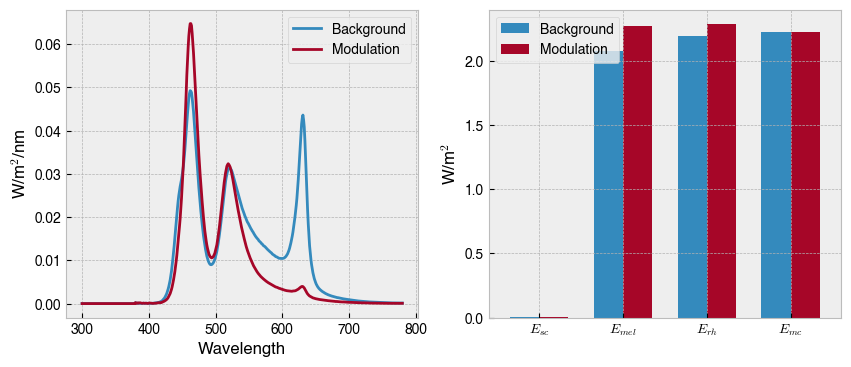

In [5]:
# Plot solution
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ssp.plot_solution_spds(solution.x, ax=axs[0])
ssp.plot_solution_aopic(solution.x, ax=axs[1])
axs[1].set_ylabel('W/m$^2$');

In general, silent substitution is challenging in mice because of the significant overlap of the M-cone, melanopic and rhodopic action spectra. Some studies have got around this problem by using red-cone knock-in mouse models (e.g., [Storchi et al., 2015](https://www.pnas.org/doi/10.1073/pnas.1505274112); [Allen et al., 2014](https://www.cell.com/current-biology/fulltext/S0960-9822(14)01135-X)) where the spectral sensitivity of the M-cone is shifted rightward. A stimulation system with optimised LED wavelengths will also help with the spectral separation of the photopigments.